# Same notebook as polarization.ipynb but rerun

# This new ML pipeline enables equal representation of each polarization state in each train, test, and validation dataset
### In the future, if needed, refactor into functions for efficiency

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [3]:
from core.getdata import *
from core.dataset import *
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [6]:
asd = DatasetPolar(ligands, polarization, replicas, size)

In [7]:
asd.labels.shape

(69552,)

In [8]:
m0 = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [9]:
print(len(m0), len(ib), len(ig), len(i0), len(i3), len(i4))

11592 11592 11592 11592 11592 11592


In [10]:
m0_train, m0_val, m0_test = torch.utils.data.random_split(m0, [6956, 2318, 2318])
ib_train, ib_val, ib_test = torch.utils.data.random_split(ib, [6956, 2318, 2318])
ig_train, ig_val, ig_test = torch.utils.data.random_split(ig, [6956, 2318, 2318])
i0_train, i0_val, i0_test = torch.utils.data.random_split(i0, [6956, 2318, 2318])
i3_train, i3_val, i3_test = torch.utils.data.random_split(i3, [6956, 2318, 2318])
i4_train, i4_val, i4_test = torch.utils.data.random_split(i4, [6956, 2318, 2318])

In [11]:
# extract all data and labels from each torch subset object and refactor into my own objects

def extract_xy(subsets):
    train, val, test = subsets # unpack tuple
    train_X = [item[0] for item in train]
    train_Y = [item[1] for item in train]
    val_X = [item[0] for item in val]
    val_Y = [item[1] for item in val]
    test_X = [item[0] for item in test]
    test_Y = [item[1] for item in test]
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [12]:
m0_train_X, m0_train_Y, m0_val_X, m0_val_Y, m0_test_X, m0_test_Y = extract_xy((m0_train, m0_val, m0_test))
ib_train_X, ib_train_Y, ib_val_X, ib_val_Y, ib_test_X, ib_test_Y = extract_xy((ib_train, ib_val, ib_test))
ig_train_X, ig_train_Y, ig_val_X, ig_val_Y, ig_test_X, ig_test_Y = extract_xy((ig_train, ig_val, ig_test))
i0_train_X, i0_train_Y, i0_val_X, i0_val_Y, i0_test_X, i0_test_Y = extract_xy((i0_train, i0_val, i0_test))
i3_train_X, i3_train_Y, i3_val_X, i3_val_Y, i3_test_X, i3_test_Y = extract_xy((i3_train, i3_val, i3_test))
i4_train_X, i4_train_Y, i4_val_X, i4_val_Y, i4_test_X, i4_test_Y = extract_xy((i4_train, i4_val, i4_test))

In [13]:
# split into 60/20/20 for each polarization dataset
# more empirical method to analyze model metrics across each polarization

# X = np.vstack([m0.data, ib.data, ig.data, i0.data, i3.data, i4.data])
# Y = np.hstack([m0.labels, ib.labels, ig.labels, i0.labels, i3.labels, i4.labels])

In [14]:
class TorchData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
# need to concat all train_X and train_Y into one dataset for training
train_X = np.vstack([m0_train_X, ib_train_X, ig_train_X, i0_train_X, i3_train_X, i4_train_X])
train_Y = np.hstack([m0_train_Y, ib_train_Y, ig_train_Y, i0_train_Y, i3_train_Y, i4_train_Y])

val_X = np.vstack([m0_val_X, ib_val_X, ig_val_X, i0_val_X, i3_val_X, i4_val_X])
val_Y = np.hstack([m0_val_Y, ib_val_Y, ig_val_Y, i0_val_Y, i3_val_Y, i4_val_Y])

test_X = np.vstack([m0_test_X, ib_test_X, ig_test_X, i0_test_X, i3_test_X, i4_test_X])
test_Y = np.hstack([m0_test_Y, ib_test_Y, ig_test_Y, i0_test_Y, i3_test_Y, i4_test_Y])

In [16]:
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

(41736, 98, 1) (41736,)
(13908, 98, 1) (13908,)
(13908, 98, 1) (13908,)


In [17]:
train = TorchData(train_X, train_Y)
val = TorchData(val_X, val_Y)
test = TorchData(test_X, test_Y)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [19]:
# hyperparameters
input_size = 1
hidden_size = 98
output_size = 9

lr = 0.001
n_epochs = 70
batch_size = 64
device = torch.device('cuda')

In [20]:
net = LSTM(input_size=input_size, hidden_sizes=hidden_size, output_size=output_size, num_layers=1, device=device)

In [21]:
net.train()

LSTM(
  (lstm): LSTM(1, 98, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [22]:
trainer = LSTMTrainer(model=net, device=device)

In [23]:
trainer.train(trainloader, valloader, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:04<04:59,  4.34s/it]

Epoch 001: | Training Loss: 2.1699654135915805 | Validation Loss: 2.169209270302309


  3%|██▎                                                                                | 2/70 [00:08<04:31,  3.99s/it]

Epoch 002: | Training Loss: 2.1617391638879937 | Validation Loss: 2.1441567797179615


  4%|███▌                                                                               | 3/70 [00:11<04:20,  3.89s/it]

Epoch 003: | Training Loss: 2.170363706980146 | Validation Loss: 2.2019908996897004


  6%|████▋                                                                              | 4/70 [00:15<04:12,  3.83s/it]

Epoch 004: | Training Loss: 2.1939807065960824 | Validation Loss: 2.1868157878928227


  7%|█████▉                                                                             | 5/70 [00:19<04:11,  3.87s/it]

Epoch 005: | Training Loss: 2.1311015701220923 | Validation Loss: 2.098080339781735


  9%|███████                                                                            | 6/70 [00:23<04:03,  3.81s/it]

Epoch 006: | Training Loss: 2.007701017407509 | Validation Loss: 1.9228259368773994


 10%|████████▎                                                                          | 7/70 [00:26<03:55,  3.74s/it]

Epoch 007: | Training Loss: 1.8596414818698013 | Validation Loss: 1.8657165836850438


 11%|█████████▍                                                                         | 8/70 [00:30<03:47,  3.68s/it]

Epoch 008: | Training Loss: 1.7958650985136515 | Validation Loss: 1.7459584890155617


 13%|██████████▋                                                                        | 9/70 [00:33<03:41,  3.63s/it]

Epoch 009: | Training Loss: 1.7300660128250238 | Validation Loss: 1.6868755522124264


 14%|███████████▋                                                                      | 10/70 [00:37<03:36,  3.60s/it]

Epoch 010: | Training Loss: 1.6863569174572302 | Validation Loss: 1.7543782559009866


 16%|████████████▉                                                                     | 11/70 [00:41<03:34,  3.64s/it]

Epoch 011: | Training Loss: 1.6737505611927914 | Validation Loss: 1.6397087770864505


 17%|██████████████                                                                    | 12/70 [00:45<03:35,  3.72s/it]

Epoch 012: | Training Loss: 1.6349898762943915 | Validation Loss: 1.6253428672431807


 19%|███████████████▏                                                                  | 13/70 [00:48<03:29,  3.67s/it]

Epoch 013: | Training Loss: 1.6130689052126126 | Validation Loss: 1.583277776700641


 20%|████████████████▍                                                                 | 14/70 [00:52<03:24,  3.65s/it]

Epoch 014: | Training Loss: 1.6095425708370588 | Validation Loss: 1.5805301518615233


 21%|█████████████████▌                                                                | 15/70 [00:55<03:20,  3.64s/it]

Epoch 015: | Training Loss: 1.6240576713775237 | Validation Loss: 1.5951083286092915


 23%|██████████████████▋                                                               | 16/70 [00:59<03:20,  3.72s/it]

Epoch 016: | Training Loss: 1.5751032279790087 | Validation Loss: 1.5441031423183755


 24%|███████████████████▉                                                              | 17/70 [01:03<03:16,  3.70s/it]

Epoch 017: | Training Loss: 1.7752378731737823 | Validation Loss: 1.9488237833758013


 26%|█████████████████████                                                             | 18/70 [01:07<03:11,  3.68s/it]

Epoch 018: | Training Loss: 1.8780272645935714 | Validation Loss: 2.094143180672182


 27%|██████████████████████▎                                                           | 19/70 [01:10<03:09,  3.71s/it]

Epoch 019: | Training Loss: 1.9519503797542812 | Validation Loss: 1.8687845003714256


 29%|███████████████████████▍                                                          | 20/70 [01:14<03:05,  3.72s/it]

Epoch 020: | Training Loss: 1.733160803182932 | Validation Loss: 1.650484863771211


 30%|████████████████████████▌                                                         | 21/70 [01:18<02:59,  3.67s/it]

Epoch 021: | Training Loss: 1.6429163463995613 | Validation Loss: 1.6183629965563433


 31%|█████████████████████████▊                                                        | 22/70 [01:21<02:54,  3.63s/it]

Epoch 022: | Training Loss: 1.5901834510186912 | Validation Loss: 1.5657275860462714


 33%|██████████████████████████▉                                                       | 23/70 [01:25<02:49,  3.60s/it]

Epoch 023: | Training Loss: 1.5809997997459189 | Validation Loss: 1.560862340511532


 34%|████████████████████████████                                                      | 24/70 [01:28<02:45,  3.59s/it]

Epoch 024: | Training Loss: 1.5483727015178383 | Validation Loss: 1.5215894995479409


 36%|█████████████████████████████▎                                                    | 25/70 [01:32<02:41,  3.58s/it]

Epoch 025: | Training Loss: 1.5153476629651523 | Validation Loss: 1.5100064058916285


 37%|██████████████████████████████▍                                                   | 26/70 [01:35<02:37,  3.58s/it]

Epoch 026: | Training Loss: 1.4960110406598124 | Validation Loss: 1.4963380163962687


 39%|███████████████████████████████▋                                                  | 27/70 [01:39<02:33,  3.58s/it]

Epoch 027: | Training Loss: 1.4820181593230453 | Validation Loss: 1.4665510036529752


 40%|████████████████████████████████▊                                                 | 28/70 [01:43<02:30,  3.59s/it]

Epoch 028: | Training Loss: 1.4602626078344232 | Validation Loss: 1.4704357921530347


 41%|█████████████████████████████████▉                                                | 29/70 [01:46<02:26,  3.58s/it]

Epoch 029: | Training Loss: 1.4427101246978387 | Validation Loss: 1.4465273760874338


 43%|███████████████████████████████████▏                                              | 30/70 [01:50<02:23,  3.59s/it]

Epoch 030: | Training Loss: 1.424312973369318 | Validation Loss: 1.4389674674480333


 44%|████████████████████████████████████▎                                             | 31/70 [01:53<02:19,  3.58s/it]

Epoch 031: | Training Loss: 1.4175168907478064 | Validation Loss: 1.4047945694092216


 46%|█████████████████████████████████████▍                                            | 32/70 [01:57<02:15,  3.58s/it]

Epoch 032: | Training Loss: 1.3943186408710333 | Validation Loss: 1.3951116488614212


 47%|██████████████████████████████████████▋                                           | 33/70 [02:00<02:12,  3.58s/it]

Epoch 033: | Training Loss: 1.377337078223002 | Validation Loss: 1.3882179571947921


 49%|███████████████████████████████████████▊                                          | 34/70 [02:04<02:08,  3.58s/it]

Epoch 034: | Training Loss: 1.3654503298389966 | Validation Loss: 1.3658274439496731


 50%|█████████████████████████████████████████                                         | 35/70 [02:08<02:05,  3.59s/it]

Epoch 035: | Training Loss: 1.364101562620487 | Validation Loss: 1.382819589124907


 51%|██████████████████████████████████████████▏                                       | 36/70 [02:11<02:01,  3.58s/it]

Epoch 036: | Training Loss: 1.3485069958575835 | Validation Loss: 1.3411811743307551


 53%|███████████████████████████████████████████▎                                      | 37/70 [02:15<01:58,  3.58s/it]

Epoch 037: | Training Loss: 1.3264368061449772 | Validation Loss: 1.3559188859178386


 54%|████████████████████████████████████████████▌                                     | 38/70 [02:18<01:54,  3.57s/it]

Epoch 038: | Training Loss: 1.3188177184708085 | Validation Loss: 1.3706505856382738


 56%|█████████████████████████████████████████████▋                                    | 39/70 [02:22<01:51,  3.60s/it]

Epoch 039: | Training Loss: 1.323956651946852 | Validation Loss: 1.395698796171661


 57%|██████████████████████████████████████████████▊                                   | 40/70 [02:26<01:49,  3.65s/it]

Epoch 040: | Training Loss: 1.3082787400913092 | Validation Loss: 1.3081955852311686


 59%|████████████████████████████████████████████████                                  | 41/70 [02:30<01:46,  3.68s/it]

Epoch 041: | Training Loss: 1.2873826779961404 | Validation Loss: 1.30979804079467


 60%|█████████████████████████████████████████████████▏                                | 42/70 [02:33<01:42,  3.68s/it]

Epoch 042: | Training Loss: 1.2774686604327483 | Validation Loss: 1.3214372713631446


 61%|██████████████████████████████████████████████████▎                               | 43/70 [02:37<01:39,  3.67s/it]

Epoch 043: | Training Loss: 1.2788216662443432 | Validation Loss: 1.317490777564705


 63%|███████████████████████████████████████████████████▌                              | 44/70 [02:40<01:34,  3.65s/it]

Epoch 044: | Training Loss: 1.2658885707351368 | Validation Loss: 1.2991796726480536


 64%|████████████████████████████████████████████████████▋                             | 45/70 [02:44<01:30,  3.63s/it]

Epoch 045: | Training Loss: 1.2538884137892614 | Validation Loss: 1.30202717956053


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [02:48<01:26,  3.62s/it]

Epoch 046: | Training Loss: 1.3002705273730466 | Validation Loss: 1.3496270691036085


 67%|███████████████████████████████████████████████████████                           | 47/70 [02:51<01:22,  3.61s/it]

Epoch 047: | Training Loss: 1.2435070290864882 | Validation Loss: 1.3066251800147766


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [02:55<01:19,  3.60s/it]

Epoch 048: | Training Loss: 1.2429218333311505 | Validation Loss: 1.3026021057312642


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [02:58<01:15,  3.59s/it]

Epoch 049: | Training Loss: 1.2934072173755349 | Validation Loss: 1.28839146626105


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [03:02<01:11,  3.59s/it]

Epoch 050: | Training Loss: 1.2312866651080834 | Validation Loss: 1.26127616418611


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [03:06<01:08,  3.59s/it]

Epoch 051: | Training Loss: 1.2189451365704558 | Validation Loss: 1.2801093524749125


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [03:09<01:04,  3.59s/it]

Epoch 052: | Training Loss: 1.213285595132965 | Validation Loss: 1.282835432969102


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [03:13<01:01,  3.59s/it]

Epoch 053: | Training Loss: 1.2055350071985909 | Validation Loss: 1.2632883243057706


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [03:16<00:57,  3.59s/it]

Epoch 054: | Training Loss: 1.1994565143884597 | Validation Loss: 1.2589056579344864


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [03:20<00:53,  3.59s/it]

Epoch 055: | Training Loss: 1.2186940071411192 | Validation Loss: 1.25314493901139


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [03:24<00:50,  3.59s/it]

Epoch 056: | Training Loss: 1.1741003167757031 | Validation Loss: 1.2591233885069506


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [03:27<00:46,  3.59s/it]

Epoch 057: | Training Loss: 1.1726235763767412 | Validation Loss: 1.2355067415521779


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [03:31<00:43,  3.59s/it]

Epoch 058: | Training Loss: 1.1710157823416576 | Validation Loss: 1.2550768551476505


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [03:34<00:39,  3.59s/it]

Epoch 059: | Training Loss: 1.1659093468149078 | Validation Loss: 1.227753264641543


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [03:38<00:35,  3.59s/it]

Epoch 060: | Training Loss: 1.1608616159301806 | Validation Loss: 1.240028891814958


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [03:41<00:32,  3.58s/it]

Epoch 061: | Training Loss: 1.1525670697093924 | Validation Loss: 1.2166297690037193


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [03:45<00:28,  3.58s/it]

Epoch 062: | Training Loss: 1.1479752663448795 | Validation Loss: 1.221614060598776


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [03:49<00:25,  3.58s/it]

Epoch 063: | Training Loss: 1.1365584009091667 | Validation Loss: 1.2538997429773349


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [03:52<00:21,  3.58s/it]

Epoch 064: | Training Loss: 1.131888308075997 | Validation Loss: 1.2121920213786834


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [03:56<00:17,  3.58s/it]

Epoch 065: | Training Loss: 1.1297403264556873 | Validation Loss: 1.2052139210591621


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [03:59<00:14,  3.59s/it]

Epoch 066: | Training Loss: 1.1066681471571989 | Validation Loss: 1.2054464048748716


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [04:03<00:10,  3.58s/it]

Epoch 067: | Training Loss: 1.1093266375397102 | Validation Loss: 1.2174370469303306


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [04:07<00:07,  3.58s/it]

Epoch 068: | Training Loss: 1.1265690606914656 | Validation Loss: 1.200283660527763


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [04:10<00:03,  3.58s/it]

Epoch 069: | Training Loss: 1.0817451441452295 | Validation Loss: 1.1979846309084412


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [04:14<00:00,  3.63s/it]

Epoch 070: | Training Loss: 1.0816496579606902 | Validation Loss: 1.205848779700218


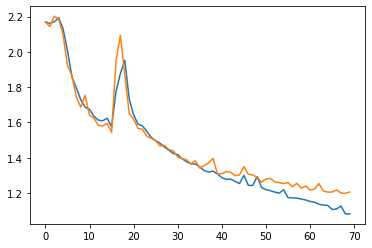

In [24]:
# visualize training/validation loss
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

# some forgetting, could rerun

In [25]:
# trainer.evaluate with testloader
prob, pred, true = trainer.evaluate(testloader)

In [26]:
from sklearn.metrics import classification_report

In [27]:
cr = classification_report(true, pred, target_names=ligands)

In [28]:
print(cr) # similar results to apeksha's model ~ 55% accuracy

              precision    recall  f1-score   support

         TNF       0.57      0.61      0.59      1529
         R84       0.65      0.78      0.71      1534
         PIC       0.60      0.60      0.60      1481
         P3K       0.56      0.53      0.55      1537
         FLA       0.43      0.43      0.43      1548
         CpG       0.44      0.40      0.42      1573
         FSL       0.35      0.26      0.29      1562
         LPS       0.45      0.50      0.48      1582
         UST       0.94      0.99      0.96      1562

    accuracy                           0.57     13908
   macro avg       0.56      0.57      0.56     13908
weighted avg       0.55      0.57      0.56     13908



In [29]:
fraction = Fraction(true, prob)

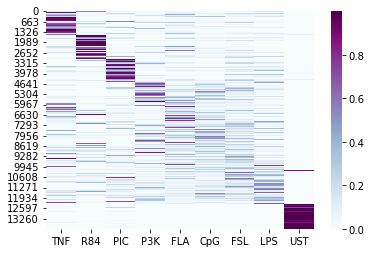

In [30]:
cf = sns.heatmap(fraction, cmap="BuPu", xticklabels=ligands)

## Polarization State Analysis

In [31]:
# refactor each polarization test_X and test_Y into torchdata object
# evaluate each one separately then concat and evaluate holistically

m0_test = TorchData(m0_test_X, m0_test_Y)
ib_test = TorchData(ib_test_X, ib_test_Y)
ig_test = TorchData(ig_test_X, ig_test_Y)
i0_test = TorchData(i0_test_X, i0_test_Y)
i3_test = TorchData(i3_test_X, i3_test_Y)
i4_test = TorchData(i4_test_X, i4_test_Y)

In [32]:
m0_loader = torch.utils.data.DataLoader(m0_test, batch_size=64, shuffle=True)
ib_loader = torch.utils.data.DataLoader(ib_test, batch_size=64, shuffle=True)
ig_loader = torch.utils.data.DataLoader(ig_test, batch_size=64, shuffle=True)
i0_loader = torch.utils.data.DataLoader(i0_test, batch_size=64, shuffle=True)
i3_loader = torch.utils.data.DataLoader(i3_test, batch_size=64, shuffle=True)
i4_loader = torch.utils.data.DataLoader(i4_test, batch_size=64, shuffle=True)

In [33]:
m0_prob, m0_pred, m0_true = trainer.evaluate(m0_loader)

In [34]:
ib_prob, ib_pred, ib_true = trainer.evaluate(ib_loader)

In [35]:
ig_prob, ig_pred, ig_true = trainer.evaluate(ig_loader)

In [36]:
i0_prob, i0_pred, i0_true = trainer.evaluate(i0_loader)

In [37]:
i3_prob, i3_pred, i3_true = trainer.evaluate(i3_loader)

In [38]:
i4_prob, i4_pred, i4_true = trainer.evaluate(i4_loader)

### M0

              precision    recall  f1-score      support
TNF            0.583039  0.673469  0.625000   245.000000
R84            0.624294  0.866667  0.725780   255.000000
PIC            0.758475  0.745833  0.752101   240.000000
P3K            0.452459  0.554217  0.498195   249.000000
FLA            0.492000  0.434629  0.461538   283.000000
CpG            0.435897  0.444030  0.439926   268.000000
FSL            0.447761  0.225564  0.300000   266.000000
LPS            0.613169  0.543796  0.576402   274.000000
UST            0.983333  0.991597  0.987448   238.000000
accuracy       0.599655  0.599655  0.599655     0.599655
macro avg      0.598936  0.608867  0.596266  2318.000000
weighted avg   0.592726  0.599655  0.588445  2318.000000


<AxesSubplot:>

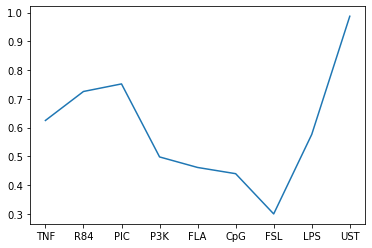

In [39]:
m0_cr = classification_report(m0_true, m0_pred, target_names=ligands, output_dict=True)
m0_crdf = pd.DataFrame(m0_cr).transpose()
print(m0_crdf)

m0_crdf[:9]['f1-score'].plot()

### ib

              precision    recall  f1-score     support
TNF            0.556962  0.513619  0.534413   257.00000
R84            0.712766  0.788235  0.748603   255.00000
PIC            0.535156  0.543651  0.539370   252.00000
P3K            0.705000  0.520295  0.598726   271.00000
FLA            0.477941  0.509804  0.493359   255.00000
CpG            0.502128  0.452107  0.475806   261.00000
FSL            0.369458  0.324675  0.345622   231.00000
LPS            0.442815  0.596838  0.508418   253.00000
UST            0.958904  0.989399  0.973913   283.00000
accuracy       0.588870  0.588870  0.588870     0.58887
macro avg      0.584570  0.582069  0.579803  2318.00000
weighted avg   0.592099  0.588870  0.586925  2318.00000


<AxesSubplot:>

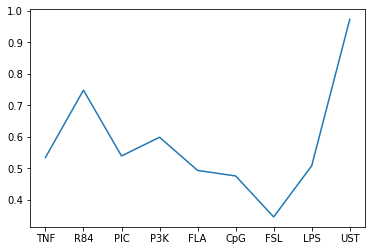

In [40]:
ib_cr = classification_report(ib_true, ib_pred, target_names=ligands, output_dict=True)
ib_crdf = pd.DataFrame(ib_cr).transpose()
print(ib_crdf)

ib_crdf[:9]['f1-score'].plot()

### ig

              precision    recall  f1-score      support
TNF            0.689362  0.658537  0.673597   246.000000
R84            0.688103  0.816794  0.746946   262.000000
PIC            0.601504  0.318725  0.416667   251.000000
P3K            0.474403  0.526515  0.499102   264.000000
FLA            0.322275  0.274194  0.296296   248.000000
CpG            0.380952  0.275862  0.320000   261.000000
FSL            0.222222  0.198473  0.209677   262.000000
LPS            0.353468  0.605364  0.446328   261.000000
UST            0.973585  0.980989  0.977273   263.000000
accuracy       0.518982  0.518982  0.518982     0.518982
macro avg      0.522875  0.517272  0.509543  2318.000000
weighted avg   0.522851  0.518982  0.510441  2318.000000


<AxesSubplot:>

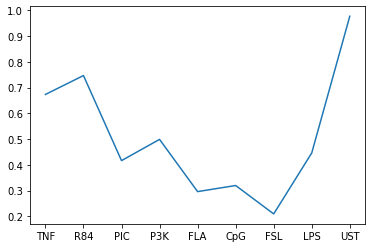

In [41]:
ig_cr = classification_report(ig_true, ig_pred, target_names=ligands, output_dict=True)
ig_crdf = pd.DataFrame(ig_cr).transpose()
print(ig_crdf)

ig_crdf[:9]['f1-score'].plot()

### i0

              precision    recall  f1-score      support
TNF            0.595819  0.662791  0.627523   258.000000
R84            0.582840  0.800813  0.674658   246.000000
PIC            0.640496  0.617530  0.628803   251.000000
P3K            0.460465  0.392857  0.423983   252.000000
FLA            0.365385  0.299213  0.329004   254.000000
CpG            0.435294  0.412639  0.423664   269.000000
FSL            0.341727  0.372549  0.356473   255.000000
LPS            0.500000  0.416667  0.454545   276.000000
UST            0.950943  0.980545  0.965517   257.000000
accuracy       0.548318  0.548318  0.548318     0.548318
macro avg      0.541441  0.550623  0.542686  2318.000000
weighted avg   0.540697  0.548318  0.541228  2318.000000


<AxesSubplot:>

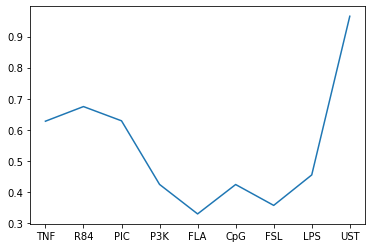

In [42]:
i0_cr = classification_report(i0_true, i0_pred, target_names=ligands, output_dict=True)
i0_crdf = pd.DataFrame(i0_cr).transpose()
print(i0_crdf)

i0_crdf[:9]['f1-score'].plot()

### i3

              precision    recall  f1-score      support
TNF            0.543974  0.607273  0.573883   275.000000
R84            0.609756  0.775194  0.682594   258.000000
PIC            0.589286  0.708155  0.643275   233.000000
P3K            0.622449  0.486056  0.545861   251.000000
FLA            0.449275  0.473282  0.460967   262.000000
CpG            0.394191  0.358491  0.375494   265.000000
FSL            0.365854  0.221402  0.275862   271.000000
LPS            0.424000  0.418972  0.421471   253.000000
UST            0.891304  0.984000  0.935361   250.000000
accuracy       0.554357  0.554357  0.554357     0.554357
macro avg      0.543343  0.559203  0.546085  2318.000000
weighted avg   0.540062  0.554357  0.541989  2318.000000


<AxesSubplot:>

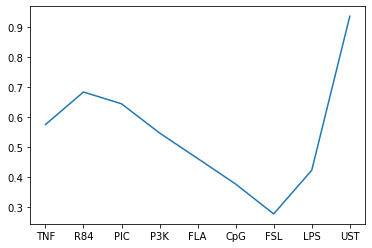

In [43]:
i3_cr = classification_report(i3_true, i3_pred, target_names=ligands, output_dict=True)
i3_crdf = pd.DataFrame(i3_cr).transpose()
print(i3_crdf)

i3_crdf[:9]['f1-score'].plot()

### i4

              precision    recall  f1-score      support
TNF            0.484962  0.520161  0.501946   248.000000
R84            0.688797  0.643411  0.665331   258.000000
PIC            0.508621  0.696850  0.588040   254.000000
P3K            0.742857  0.728000  0.735354   250.000000
FLA            0.459732  0.556911  0.503676   246.000000
CpG            0.502222  0.453815  0.476793   249.000000
FSL            0.395973  0.212996  0.276995   277.000000
LPS            0.483471  0.441509  0.461538   265.000000
UST            0.884868  0.992620  0.935652   271.000000
accuracy       0.581967  0.581967  0.581967     0.581967
macro avg      0.572389  0.582919  0.571703  2318.000000
weighted avg   0.573182  0.581967  0.571424  2318.000000


<AxesSubplot:>

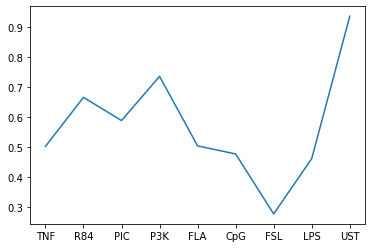

In [44]:
i4_cr = classification_report(i4_true, i4_pred, target_names=ligands, output_dict=True)
i4_crdf = pd.DataFrame(i4_cr).transpose()
print(i4_crdf)

i4_crdf[:9]['f1-score'].plot()

## Holistic

In [45]:
total_f1 = pd.concat([m0_crdf['f1-score'], ib_crdf['f1-score'], ig_crdf['f1-score'], i0_crdf['f1-score'], i3_crdf['f1-score'], i4_crdf['f1-score']], axis=1)
total_f1 = total_f1.set_axis(['M0', 'IB', 'IG', 'I0', 'I3', 'I4'], axis=1)

In [46]:
total_f1.iloc[:9]

,M0,IB,IG,I0,I3,I4
TNF,0.625000,0.534413,0.673597,0.627523,0.573883,0.501946
R84,0.725780,0.748603,0.746946,0.674658,0.682594,0.665331
PIC,0.752101,0.539370,0.416667,0.628803,0.643275,0.588040
P3K,0.498195,0.598726,0.499102,0.423983,0.545861,0.735354
FLA,0.461538,0.493359,0.296296,0.329004,0.460967,0.503676
CpG,0.439926,0.475806,0.320000,0.423664,0.375494,0.476793
FSL,0.300000,0.345622,0.209677,0.356473,0.275862,0.276995
LPS,0.576402,0.508418,0.446328,0.454545,0.421471,0.461538
UST,0.987448,0.973913,0.977273,0.965517,0.935361,0.935652


<AxesSubplot:>

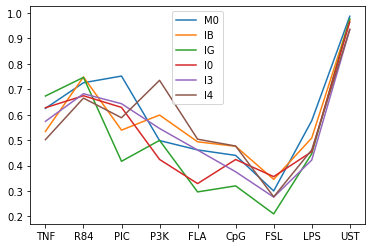

In [47]:
total_f1.iloc[:9].plot()

<AxesSubplot:>

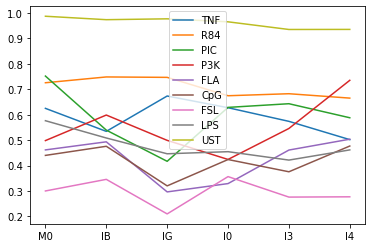

In [48]:
total_f1.iloc[:9].transpose().plot()

In [49]:
# average f1 score for all ligands across each polarization state
np.mean(total_f1.iloc[:9])

M0    0.596266
IB    0.579803
IG    0.509543
I0    0.542686
I3    0.546085
I4    0.571703
dtype: float64

<AxesSubplot:>

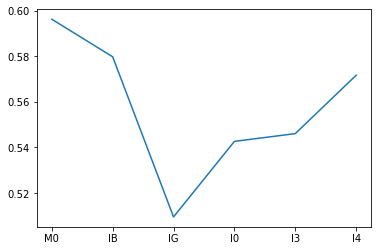

In [50]:
np.mean(total_f1.iloc[:9]).plot()